In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image
import cv2

In [2]:
# print path to data
print(os.listdir("/data/dssg/occrp/data/processed_clean"))

['shipping-receipts', 'transcripts', 'bank-statements', 'company-registry', 'court-documents', 'gazettes', 'invoices', 'passport-scan', 'receipts', 'contracts', 'middle-page']


In [3]:
# load images

data_generator = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.4,
    height_shift_range=0.4,
    zoom_range=0.3,
    rotation_range=20,
)

image_size = 224
batch_size = 10
train_generator = data_generator.flow_from_directory(
    "/data/dssg/occrp/data/processed_clean",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical",
)

num_classes = len(train_generator.class_indices)

Found 13416 images belonging to 11 classes.


In [4]:
# create resnet model
IMG_SIZE = 224
as_gray = True
n_channels = 1 if as_gray else 3

own_resnet_model = tf.keras.Sequential()
own_resnet_model.add(tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE))
if as_gray:
    own_resnet_model.add(tf.keras.layers.Lambda(tf.image.rgb_to_grayscale))
own_resnet_model.add(tf.keras.layers.Lambda(tf.image.per_image_standardization))
own_resnet_model.add(
    tf.keras.applications.ResNet50(
        include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, n_channels), pooling="avg", weights=None
    ),
)
own_resnet_model.add(tf.keras.layers.Dense(11, activation="softmax"))

2022-08-09 10:35:01.261540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 10:35:01.263762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 10:35:01.273503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thenn/.local/share/virtualenvs/dssgxdfki2022-occrp-CY4k_1kg/lib64/python3.8/site-packages/cv2/../../lib64:
2022-08-09 10:35:01.273526: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you wou

In [13]:
# some testing functions to see if model works
preprocessing_size = tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)
preprocessing_gray = tf.keras.layers.Lambda(tf.image.rgb_to_grayscale)

(576, 768, 3)


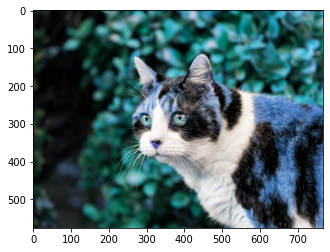

In [6]:
# load test image
cat_path = "/home/thenn/dssgxdfki2022-occrp/notebooks/feature_extraction/header_image_cat_in_heat-768x576.jpg"
img_cv2 = cv2.imread(cat_path, 1)
img_array = np.array(img_cv2)
print(img_array.shape)
plt.imshow(img_array)

(224, 224, 1)


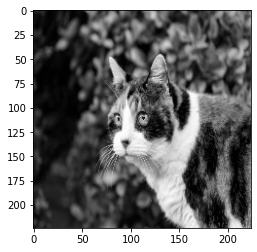

In [20]:
# test if model works
img_output = preprocessing_size(img_array).numpy()
img_output = preprocessing_gray(img_output)
print(img_output.shape)
plt.imshow(img_output, cmap="gray")

In [30]:
# compile model
own_resnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
# fit model
count = sum([len(files) for r, d, files in os.walk("/data/dssg/occrp/data/processed_clean")])

own_resnet_model.fit_generator(train_generator, steps_per_epoch=int(count / batch_size) + 1, epochs=10)

Epoch 1/10


/tmp/ipykernel_65329/2597784464.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  own_resnet_model.fit_generator(


   2/1342 [..............................] - ETA: 17:12 - loss: 6.3830 - accuracy: 0.2000  

KeyboardInterrupt: 

In [6]:
IMG_SIZE = 227
own_resnet_model = tf.keras.applications.ResNet50(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling="avg", weights=None
)

In [7]:
# summary of model
own_resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [8]:
own_resnet_model.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [9]:
own_resnet_model.input

<KerasTensor: shape=(None, 227, 227, 3) dtype=float32 (created by layer 'input_2')>